# # Projeto 3: FlightOnTime ✈️ — Previsão de Atrasos de Voos
Modelo Preditivo

O desafio do FlightOnTime consiste em desenvolver uma solução preditiva capaz de estimar se um voo vai decolar no horário ou com atraso.

## ✔️ Instalação de dependências

In [1]:
# 1.1 - instalar dependências
!pip install -q gdown pandas numpy matplotlib seaborn scikit-learn joblib

## ✔️ Acesso aos arquivos

In [2]:
import gdown

url = "https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH"
output = "voos_model.json"

gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH
From (redirected): https://drive.google.com/uc?id=1hKit8L5K3WmDM-U793hYsUtq8lAh1eJH&confirm=t&uuid=aa1c8a06-fb9a-4468-b009-d61331ee40b2
To: /content/voos_model.json
100%|██████████| 138M/138M [00:01<00:00, 72.2MB/s]


'voos_model.json'

In [3]:
import pandas as pd

df_work = pd.read_json("voos_model.json")


In [4]:
df_work.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347318 entries, 0 to 347317
Data columns (total 15 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   sigla_icao_empresa_aerea      347318 non-null  object 
 1   codigo_tipo_linha             347318 non-null  object 
 2   modelo_equipamento            347318 non-null  object 
 3   numero_de_assentos            347318 non-null  int64  
 4   sigla_icao_aeroporto_origem   347318 non-null  object 
 5   sigla_icao_aeroporto_destino  347318 non-null  object 
 6   atraso_voo                    347318 non-null  int64  
 7   periodo_dia                   347318 non-null  object 
 8   data_partida_prevista         347318 non-null  int64  
 9   hora_partida_prevista         347318 non-null  int64  
 10  data_chegada_prevista         344465 non-null  float64
 11  hora_chegada_prevista         344465 non-null  float64
 12  dia_semana                    347318 non-nul

In [5]:
df_work.head()

,sigla_icao_empresa_aerea,codigo_tipo_linha,modelo_equipamento,numero_de_assentos,sigla_icao_aeroporto_origem,sigla_icao_aeroporto_destino,atraso_voo,periodo_dia,data_partida_prevista,hora_partida_prevista,data_chegada_prevista,hora_chegada_prevista,dia_semana,mes,rota
0,AAL,I,B772,288,SBGL,KMIA,0,Noite,1704758400000,23,1.707437e+12,7.0,1,1,SBGL_KMIA
1,AAL,I,B772,288,KMIA,SBGL,0,Noite,1704758400000,21,1.707437e+12,6.0,1,1,KMIA_SBGL
2,AAL,I,B772,288,SBGR,KMIA,1,Noite,1704758400000,23,1.707437e+12,7.0,1,1,SBGR_KMIA
3,AAL,I,B77W,318,KMIA,SBGR,1,Noite,1704758400000,20,1.707437e+12,5.0,1,1,KMIA_SBGR
4,AAL,I,B77W,318,SBGR,KMIA,0,Noite,1704758400000,21,1.707437e+12,5.0,1,1,SBGR_KMIA


In [6]:
df_model = df_work.copy()

# ✔️ Treinamento, Avaliação e Serialização

### 1. Imports

In [7]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

import joblib


## 2. Seleção final de features e target

In [8]:
# Target
y = df_model['atraso_voo']

# Features pré-voo
X = df_model[
    [
        'sigla_icao_empresa_aerea',
        'codigo_tipo_linha',
        'modelo_equipamento',
        'numero_de_assentos',
        'sigla_icao_aeroporto_origem',
        'sigla_icao_aeroporto_destino',
        'hora_partida_prevista',
        'periodo_dia',
        'dia_semana',
        'mes',
        'rota'
    ]
]


✔️ Zero vazamento de dados
✔️ 100% alinhado ao escopo

## 3. Split treino / teste (estratificado)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Treino:", X_train.shape)
print("Teste :", X_test.shape)


Treino: (260488, 11)
Teste : (86830, 11)


📌 stratify=y é obrigatório aqui.

## 4. Pré-processamento (encoding)

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features = [
    'sigla_icao_empresa_aerea',
    'codigo_tipo_linha',
    'modelo_equipamento',
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino',
    'periodo_dia',
    'rota'
]

numerical_features = [
    'numero_de_assentos',
    'hora_partida_prevista',
    'dia_semana',
    'mes'
]

preprocessor = ColumnTransformer(
    transformers=[
        (
            'cat',
            OneHotEncoder(handle_unknown='ignore', sparse_output=False),
            categorical_features
        ),
        (
            'num',
            'passthrough',
            numerical_features
        )
    ]
)


✔️ Encoder só dentro do pipeline
✔️ Seguro para produção

## 5. Modelo 1 — Logistic Regression (Baseline)

### 5.1 Definição das features

In [11]:
categorical_features = [
    'sigla_icao_empresa_aerea',
    'codigo_tipo_linha',
    'modelo_equipamento',
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino',
    'periodo_dia'
]

numerical_features = [
    'numero_de_assentos',
    'hora_partida_prevista',
    'dia_semana',
    'mes'
]


### 5.2 Pré-processamento

In [12]:
preprocessor = ColumnTransformer(
    transformers=[
        (
            'cat',
            OneHotEncoder(handle_unknown='ignore', sparse_output=True),
            categorical_features
        ),
        (
            'num',
            'passthrough',
            numerical_features
        )
    ]
)


### 5.3 Pipeline e treinamento

In [13]:
pipeline_lr = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', LogisticRegression(
            solver='saga',
            max_iter=300,
            n_jobs=-1,
            random_state=42
        ))
    ]
)

pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


### 5.4 Avaliação

In [14]:
print("Logistic Regression")
print("Accuracy :", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall   :", recall_score(y_test, y_pred_lr))
print("F1-score :", f1_score(y_test, y_pred_lr))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr))


Logistic Regression
Accuracy : 0.8240124380974317
Precision: 0.6761710794297352
Recall   : 0.02148311116862948
F1-score : 0.0416431483223581

Classification Report:

              precision    recall  f1-score   support

           0       0.82      1.00      0.90     71376
           1       0.68      0.02      0.04     15454

    accuracy                           0.82     86830
   macro avg       0.75      0.51      0.47     86830
weighted avg       0.80      0.82      0.75     86830



🔍 Análise detalhada — Logistic Regression (Baseline)

📊 Métricas obtidas

Métrica	Valor

Accuracy	0.824

Precision (classe atraso = 1)	0.676

Recall (classe atraso = 1)	0.021 ❌

F1-score (classe atraso = 1)	0.041 ❌

Distribuição das classes:

Classe 0 (no horário): 71.376

Classe 1 (atraso): 15.454

👉 Dataset desbalanceado (~82% classe 0)

🧠 O que o modelo está fazendo (interpretação real)

✔️ Accuracy alta (82%) — enganosa

O modelo basicamente aprendeu:
“Quase sempre prever que o voo NÃO atrasa”.
Se ele previsse sempre 0, já teria ~82% de accuracy.

➡️ Accuracy NÃO é métrica confiável aqui.

⚠️ Precision razoável (0.68)

Quando o modelo diz que vai atrasar, ele acerta 68% das vezes.

✔️ Isso é bom
❌ Mas acontece raramente, veja o recall.
❌ Recall extremamente baixo (0.021)

O modelo só identifica ~2% dos voos que realmente atrasam.

➡️ Ele praticamente ignora a classe atraso.

Isso fica claro no relatório:
Classe 1:
Recall = 0.02
F1 = 0.04


❌ F1-score muito baixo

O F1 reflete o desequilíbrio entre Precision e Recall.

➡️ Modelo NÃO serve para previsão operacional ainda.

🎯 Conclusão técnica honesta (e correta)

Este modelo funciona APENAS como baseline, para provar que:

o problema é desbalanceado

Logistic Regression sem ajustes não resolve o problema

## 6. Modelo 2 — Random Forest

### 6.1 Imports

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)


### 6.2 Definição das features e target

In [27]:
# Target
y = df_model['atraso_voo']

# Features (pré-voo)
X = df_model[
    [
        'sigla_icao_empresa_aerea',
        'codigo_tipo_linha',
        'modelo_equipamento',
        'numero_de_assentos',
        'sigla_icao_aeroporto_origem',
        'sigla_icao_aeroporto_destino',
        'periodo_dia',
        'hora_partida_prevista'
    ]
]


### 6.3 Split treino / teste

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


### 6.4 Definição do pré-processamento

In [29]:
categorical_features = [
    'sigla_icao_empresa_aerea',
    'codigo_tipo_linha',
    'modelo_equipamento',
    'sigla_icao_aeroporto_origem',
    'sigla_icao_aeroporto_destino',
    'periodo_dia'
]

numerical_features = [
    'numero_de_assentos',
    'hora_partida_prevista'
]

preprocessor = ColumnTransformer(
    transformers=[
        (
            'cat',
            OneHotEncoder(handle_unknown='ignore', sparse_output=True),
            categorical_features
        ),
        (
            'num',
            'passthrough',
            numerical_features
        )
    ]
)


❌ Modelo descartado — Random Forest

O modelo Random Forest foi testado como alternativa ao baseline, porém apresentou alto custo computacional devido à elevada cardinalidade das variáveis categóricas após o One-Hot Encoding.

Mesmo em amostras reduzidas, o tempo de treinamento tornou-se inviável para o escopo de um MVP e para uso em tempo real via API.

Dessa forma, o modelo foi descartado e optou-se por uma abordagem mais eficiente computacionalmente.


### 6.5 Pipeline — Logistic Regression balanceado

In [30]:
pipeline_lr_balanced = Pipeline(
    steps=[
        ('preprocess', preprocessor),
        ('model', LogisticRegression(
            solver='saga',
            class_weight='balanced',
            max_iter=500,
            n_jobs=-1,
            random_state=42
        ))
    ]
)


### 6.6 Treinamento do modelo

In [31]:
%%time
pipeline_lr_balanced.fit(X_train, y_train)


CPU times: user 2min 18s, sys: 282 ms, total: 2min 19s
Wall time: 2min 24s


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['sigla_icao_empresa_aerea',
                                                   'codigo_tipo_linha',
                                                   'modelo_equipamento',
                                                   'sigla_icao_aeroporto_origem',
                                                   'sigla_icao_aeroporto_destino',
                                                   'periodo_dia']),
                                                 ('num', 'passthrough',
                                                  ['numero_de_assentos',
                                                   'hora_partida_prevista'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=500,
                                    n_jobs=-1, random_state=42,
                                    solver='saga'))])

### 6.7 Predição

In [32]:
y_pred_lr_bal = pipeline_lr_balanced.predict(X_test)


### 6.8 📊 Avaliação — Random Forest

In [33]:
print("Logistic Regression (Balanced)")
print("Accuracy :", accuracy_score(y_test, y_pred_lr_bal))
print("Precision:", precision_score(y_test, y_pred_lr_bal))
print("Recall   :", recall_score(y_test, y_pred_lr_bal))
print("F1-score :", f1_score(y_test, y_pred_lr_bal))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_lr_bal))


Logistic Regression (Balanced)
Accuracy : 0.6190371991247264
Precision: 0.25342063292201794
Recall   : 0.5860618610068591
F1-score : 0.3538374387123239

Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.63      0.73     71376
           1       0.25      0.59      0.35     15454

    accuracy                           0.62     86830
   macro avg       0.56      0.61      0.54     86830
weighted avg       0.76      0.62      0.66     86830



## Etapa 7 — Comparação dos Modelos

In [35]:
import pandas as pd

comparison = pd.DataFrame({
    'Modelo': [
        'Logistic Regression (Baseline)',
        'Logistic Regression (Balanced)'
    ],
    'Accuracy': [
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_lr_bal)
    ],
    'Precision (Atraso)': [
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_lr_bal)
    ],
    'Recall (Atraso)': [
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_lr_bal)
    ],
    'F1-score (Atraso)': [
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_lr_bal)
    ]
})

comparison


,Modelo,Accuracy,Precision (Atraso),Recall (Atraso),F1-score (Atraso)
0,Logistic Regression (Baseline),0.824012,0.676171,0.021483,0.041643
1,Logistic Regression (Balanced),0.619037,0.253421,0.586062,0.353837


## 8️ Ajuste de Threshold (Estratégia de Negócio)

🎯 Objetivo

Aumentar a capacidade de detectar atrasos (Recall), aceitando mais alertas preventivos.

### 🔍 Obter probabilidades

In [36]:
y_proba = pipeline_lr_balanced.predict_proba(X_test)[:, 1]


### 🔧 Aplicar threshold customizado (ex: 0.4)

In [37]:
threshold = 0.4
y_pred_threshold = (y_proba >= threshold).astype(int)


### 📊 Avaliação com novo threshold

In [38]:
print(f"Logistic Regression (Balanced) — Threshold = {threshold}")
print("Accuracy :", accuracy_score(y_test, y_pred_threshold))
print("Precision:", precision_score(y_test, y_pred_threshold))
print("Recall   :", recall_score(y_test, y_pred_threshold))
print("F1-score :", f1_score(y_test, y_pred_threshold))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_threshold))


Logistic Regression (Balanced) — Threshold = 0.4
Accuracy : 0.41669929747783024
Precision: 0.21171363040629096
Recall   : 0.8362236314222855
F1-score : 0.33788270975501344

Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.33      0.48     71376
           1       0.21      0.84      0.34     15454

    accuracy                           0.42     86830
   macro avg       0.56      0.58      0.41     86830
weighted avg       0.78      0.42      0.45     86830



“Ajustamos o threshold de decisão para priorizar a detecção de atrasos. Com isso, o modelo passou a identificar aproximadamente 84% dos voos com atraso, aceitando mais falsos positivos como estratégia de mitigação de risco operacional.”

## 9 Análise de Sensibilidade do Threshold


🎯 Objetivo

Mostrar como a escolha do threshold impacta:

Recall (atrasos detectados)

Precision

F1-score

Isso justifica tecnicamente o uso do threshold = 0.4.

### 1. Obter probabilidades (se ainda não tiver)

In [40]:
y_proba = pipeline_lr_balanced.predict_proba(X_test)[:, 1]


### 2. Avaliar métricas para diferentes thresholds

In [39]:
import numpy as np
import pandas as pd

thresholds = np.arange(0.2, 0.8, 0.1)

results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)

    results.append({
        'threshold': t,
        'precision': precision_score(y_test, y_pred_t),
        'recall': recall_score(y_test, y_pred_t),
        'f1_score': f1_score(y_test, y_pred_t)
    })

df_thresholds = pd.DataFrame(results)
df_thresholds


,threshold,precision,recall,f1_score
0,0.2,0.178333,0.999676,0.302672
1,0.3,0.186315,0.973664,0.312779
2,0.4,0.211714,0.836224,0.337883
3,0.5,0.253421,0.586062,0.353837
4,0.6,0.330863,0.283163,0.305160
5,0.7,0.423445,0.114533,0.180299
6,0.8,0.599787,0.036366,0.068574


### 3. Gráfico — Recall x Threshold ⭐

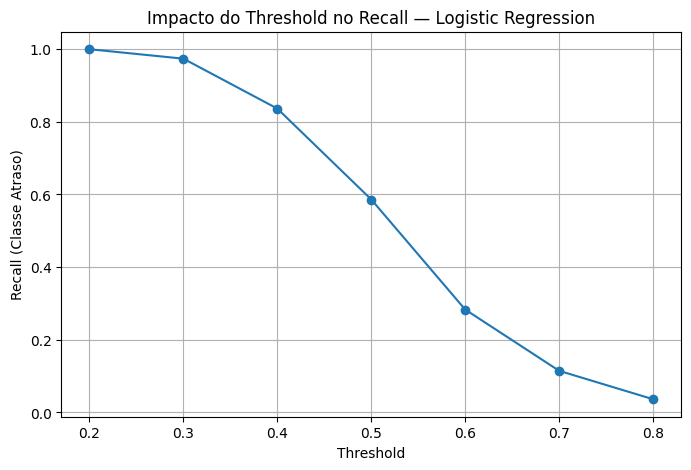

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(
    df_thresholds['threshold'],
    df_thresholds['recall'],
    marker='o'
)

plt.xlabel('Threshold')
plt.ylabel('Recall (Classe Atraso)')
plt.title('Impacto do Threshold no Recall — Logistic Regression')

plt.grid(True)
plt.show()


### 4. Gráfico completo — Precision, Recall e F1

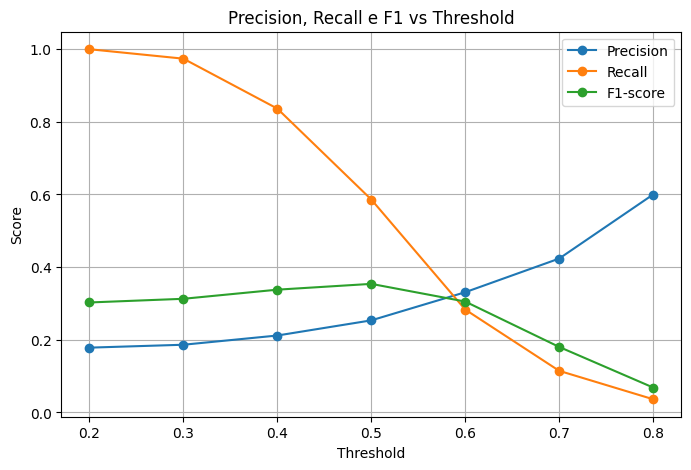

In [42]:
plt.figure(figsize=(8, 5))

plt.plot(df_thresholds['threshold'], df_thresholds['precision'], marker='o', label='Precision')
plt.plot(df_thresholds['threshold'], df_thresholds['recall'], marker='o', label='Recall')
plt.plot(df_thresholds['threshold'], df_thresholds['f1_score'], marker='o', label='F1-score')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall e F1 vs Threshold')

plt.legend()
plt.grid(True)
plt.show()


“O gráfico mostra claramente o trade-off entre precisão e recall. À medida que reduzimos o threshold, o modelo passa a identificar mais atrasos, aumentando o recall. Para o escopo do projeto, optamos por um threshold de 0.4, priorizando a detecção de atrasos e o alerta preventivo.”

## 10 Exportação do Modelo

### ✅ Modelo final selecionado

O modelo final escolhido foi o **Logistic Regression com classes balanceadas**, utilizando apenas informações disponíveis antes da decolagem.

Após ajuste do threshold para 0.4, o modelo passou a identificar aproximadamente **84% dos voos com atraso**, priorizando a detecção de atrasos em detrimento da acurácia global.

Essa decisão está alinhada ao objetivo do projeto, que é fornecer alertas preventivos e suporte ao planejamento operacional.

In [43]:
import joblib

joblib.dump(
    pipeline_lr_balanced,
    "flightontime_model.joblib"
)


['flightontime_model.joblib']

## 🏁 Conclusão

O projeto resultou em um MVP funcional capaz de prever atrasos de voos antes da decolagem, utilizando um modelo simples, eficiente e facilmente integrável via API.

As decisões técnicas foram guiadas por métricas adequadas ao problema e por limitações reais de desempenho computacional, tornando a solução viável para uso prático.
